 Working with [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is no fun, so I modified it a bit to support [CIFAR dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [32]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torch.distributions as td
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

BATCH_SIZE = 128
EPOCHS = 50
LOG_INTERVAL = 100
SEED = 42
DATA_DIR = '/vulcan/scratch/kampta/data/cifar'

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    

### Dataloaders

In [23]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.CIFAR10(root=DATA_DIR, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root=DATA_DIR, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


### Model Definition

In [11]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
#         self.bn4 = nn.BatchNorm2d(16)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(8 * 8 * 16, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc21 = nn.Linear(512, 512)
        self.fc22 = nn.Linear(512, 512)

        # Decoder
        self.fc3 = nn.Linear(512, 512)
        self.fc_bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        return self.fc21(fc1), self.fc22(fc1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 8, 8)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [25]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    REC = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return REC + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Parameters: 1880256
Train Epoch: 1 [0/50000 (0%)]	Loss: 4338.967285
Train Epoch: 1 [25600/50000 (51%)]	Loss: 611.681274
====> Epoch: 1 Average loss: 662.3871
====> Test set loss: 436.4110


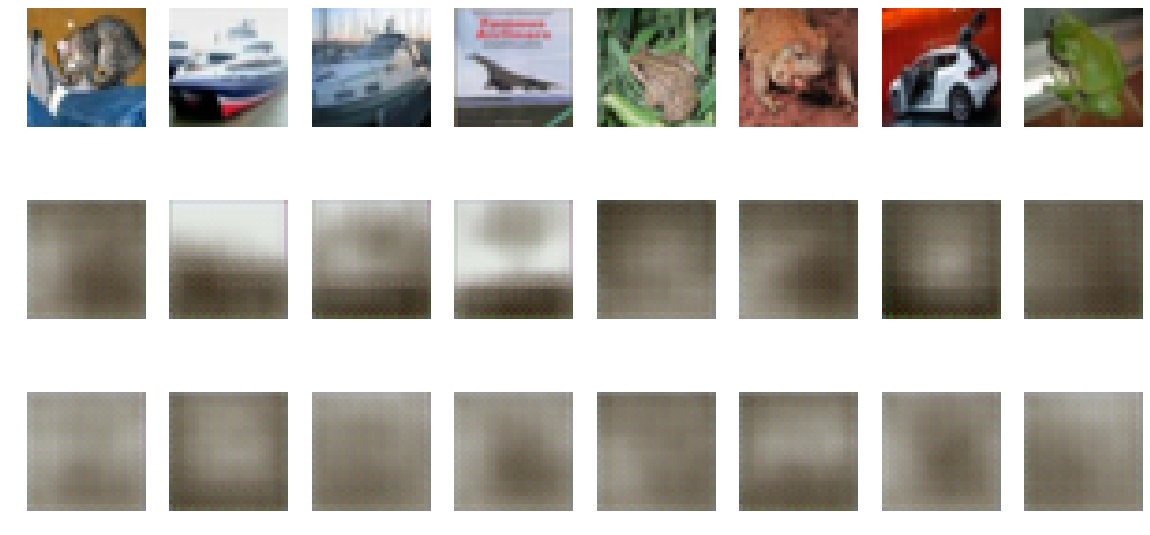

Train Epoch: 2 [0/50000 (0%)]	Loss: 417.369843
Train Epoch: 2 [25600/50000 (51%)]	Loss: 392.889313
====> Epoch: 2 Average loss: 388.5432
====> Test set loss: 363.4180


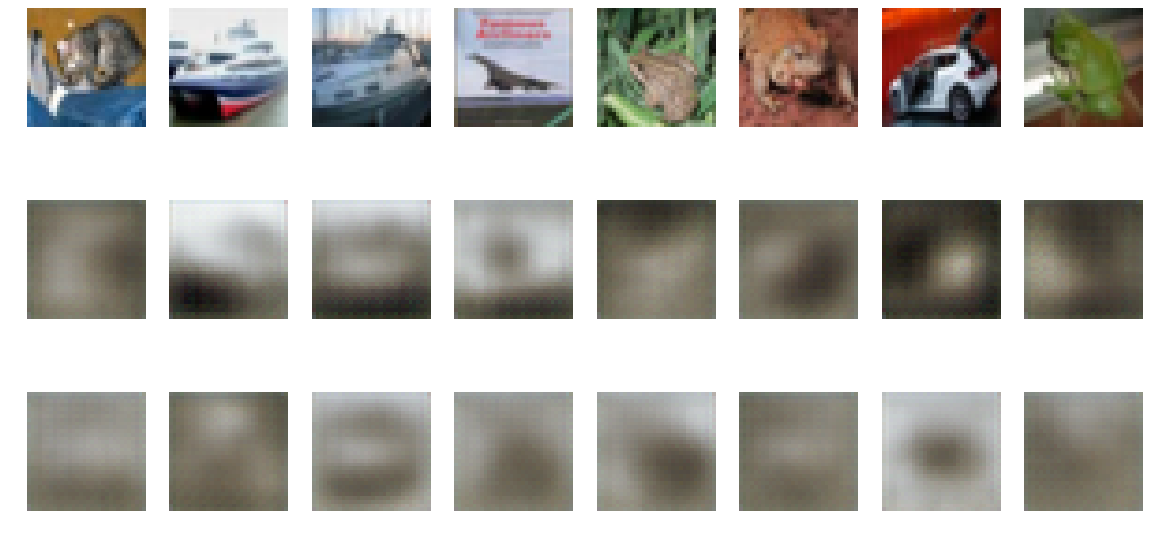

Train Epoch: 3 [0/50000 (0%)]	Loss: 353.047791
Train Epoch: 3 [25600/50000 (51%)]	Loss: 336.044128
====> Epoch: 3 Average loss: 330.9796
====> Test set loss: 304.7416


Train Epoch: 4 [0/50000 (0%)]	Loss: 299.662781
Train Epoch: 4 [25600/50000 (51%)]	Loss: 291.705414
====> Epoch: 4 Average loss: 284.5016
====> Test set loss: 276.1501


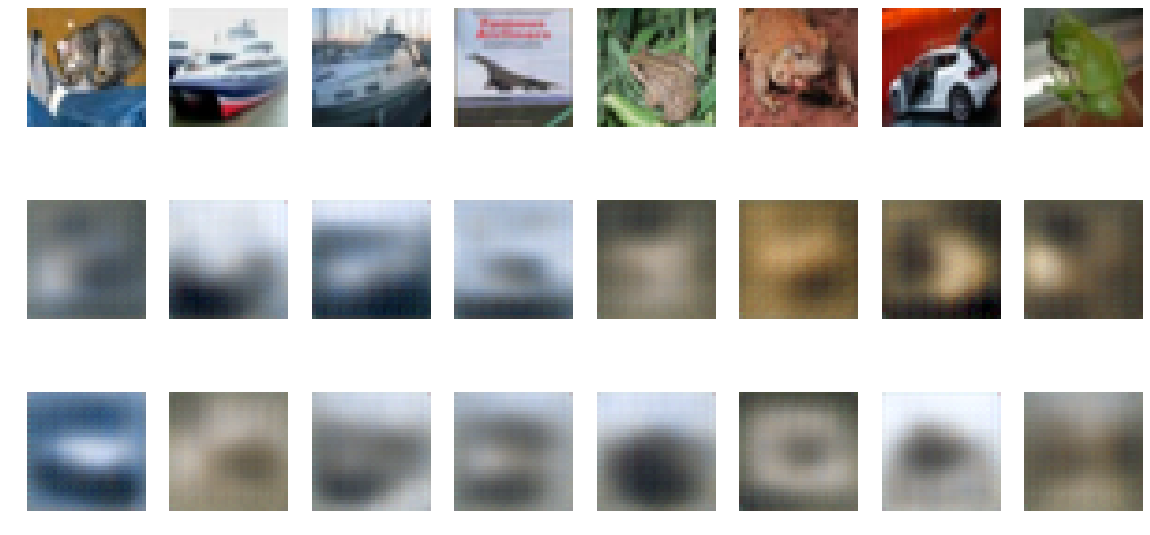

Train Epoch: 5 [0/50000 (0%)]	Loss: 268.034485
Train Epoch: 5 [25600/50000 (51%)]	Loss: 278.785675
====> Epoch: 5 Average loss: 267.0928
====> Test set loss: 259.1520


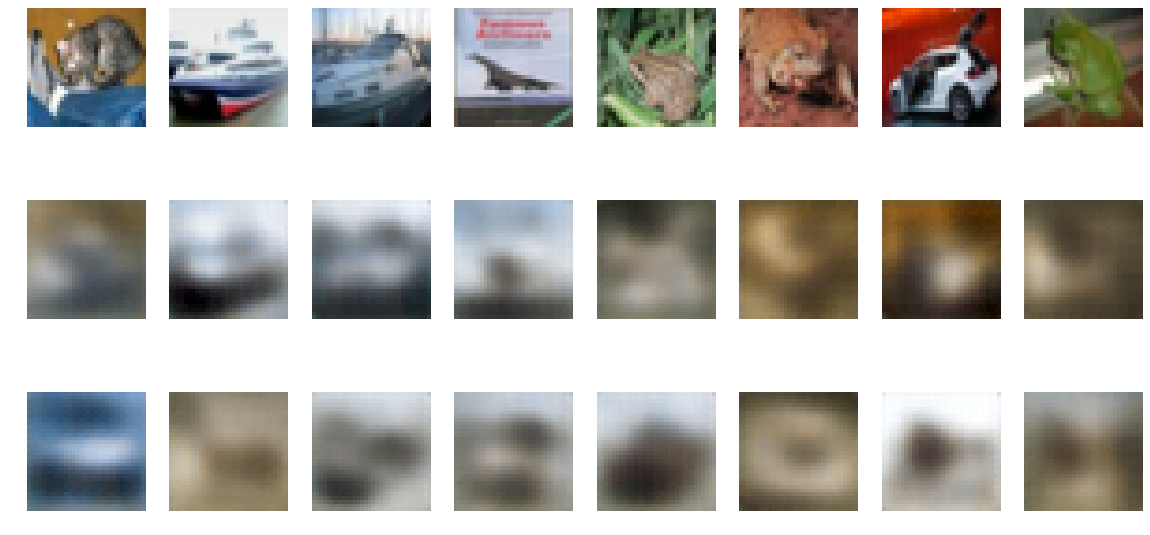

Train Epoch: 6 [0/50000 (0%)]	Loss: 267.565491
Train Epoch: 6 [25600/50000 (51%)]	Loss: 259.969177
====> Epoch: 6 Average loss: 254.9933
====> Test set loss: 258.8843


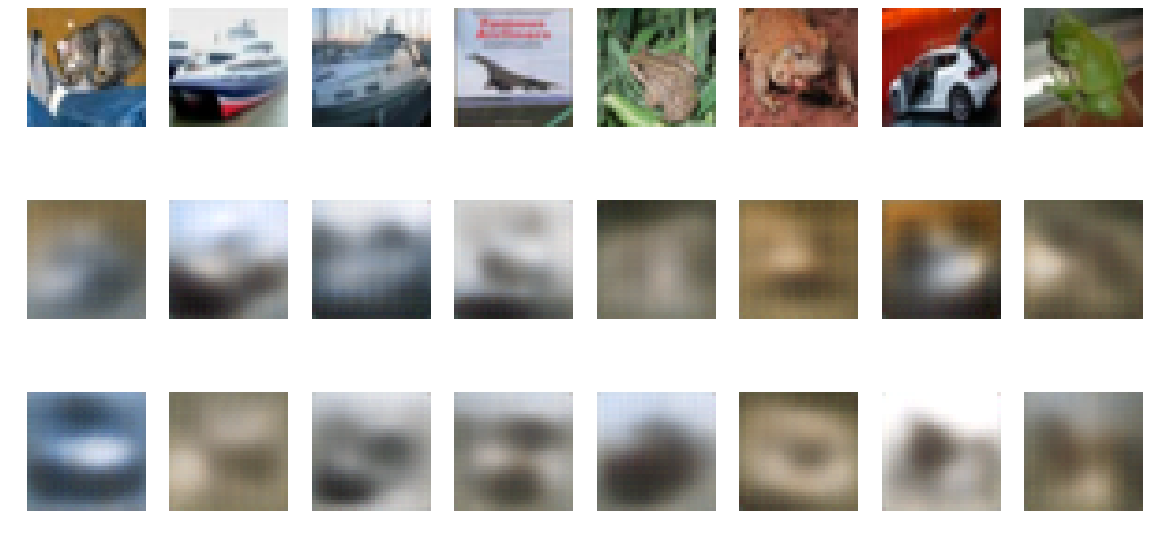

Train Epoch: 7 [0/50000 (0%)]	Loss: 248.050781
Train Epoch: 7 [25600/50000 (51%)]	Loss: 247.619934
====> Epoch: 7 Average loss: 248.6603
====> Test set loss: 242.7589


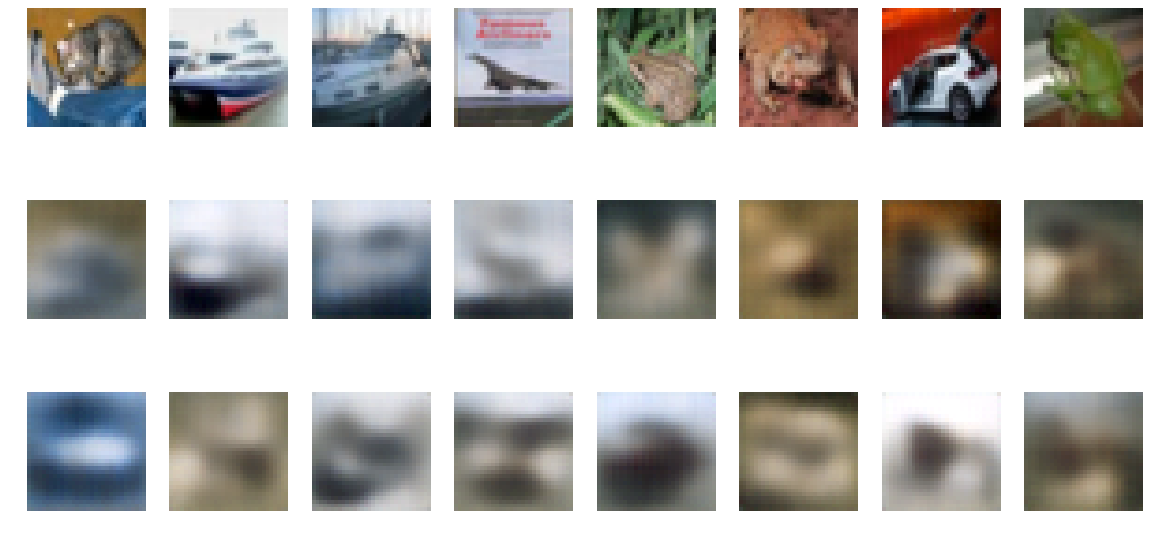

Train Epoch: 8 [0/50000 (0%)]	Loss: 238.663055
Train Epoch: 8 [25600/50000 (51%)]	Loss: 226.264038
====> Epoch: 8 Average loss: 239.6487
====> Test set loss: 240.6815


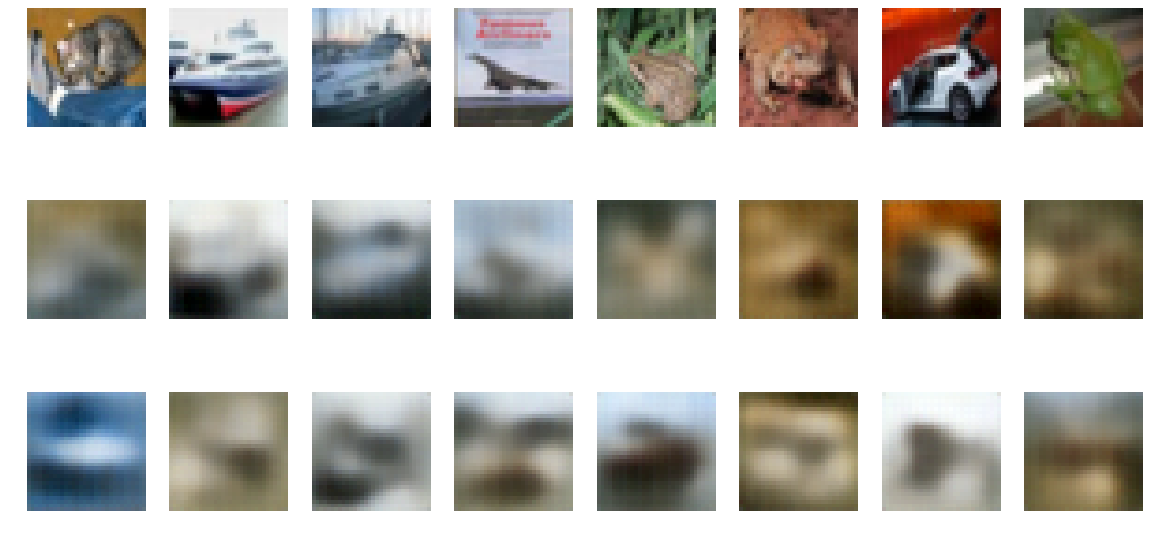

Train Epoch: 9 [0/50000 (0%)]	Loss: 241.729309
Train Epoch: 9 [25600/50000 (51%)]	Loss: 217.727081
====> Epoch: 9 Average loss: 234.0878
====> Test set loss: 235.3154


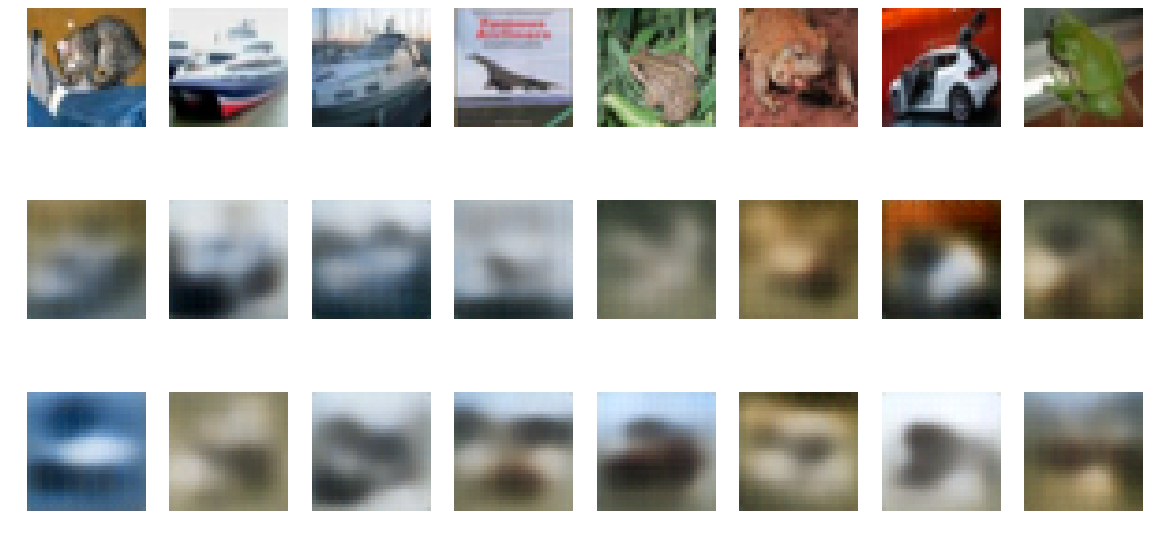

Train Epoch: 10 [0/50000 (0%)]	Loss: 239.631561
Train Epoch: 10 [25600/50000 (51%)]	Loss: 234.417007
====> Epoch: 10 Average loss: 231.6998
====> Test set loss: 230.8667


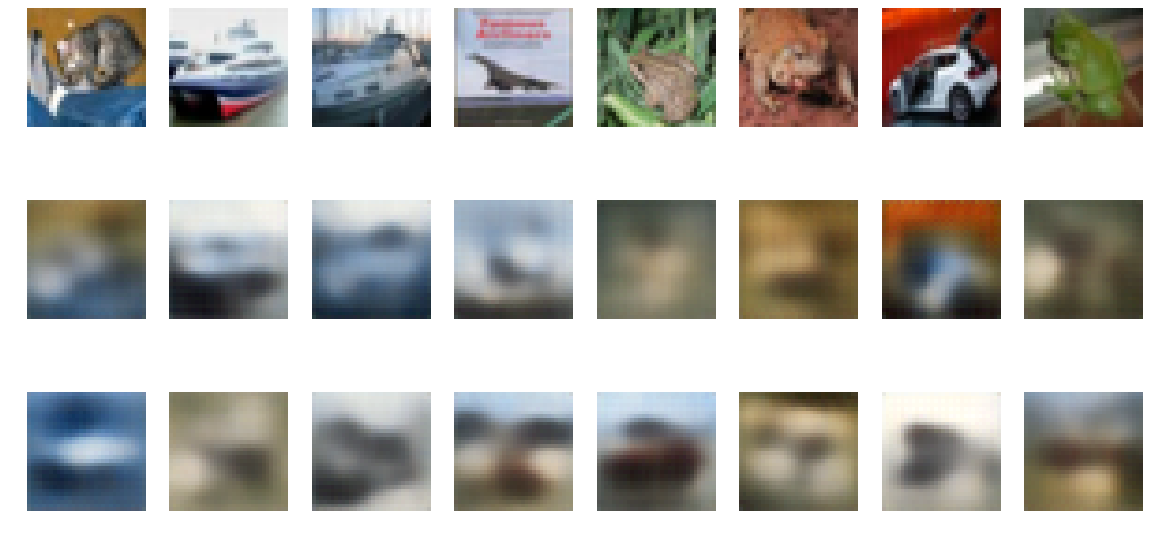

Train Epoch: 11 [0/50000 (0%)]	Loss: 232.385956
Train Epoch: 11 [25600/50000 (51%)]	Loss: 234.455872
====> Epoch: 11 Average loss: 228.7724
====> Test set loss: 224.3607


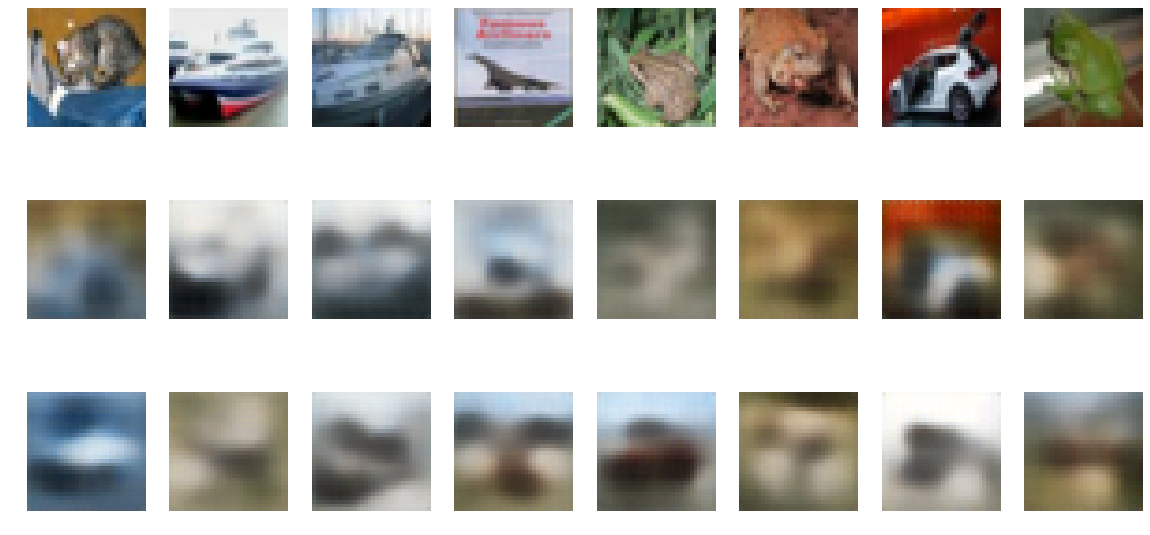

Train Epoch: 12 [0/50000 (0%)]	Loss: 229.747360
Train Epoch: 12 [25600/50000 (51%)]	Loss: 222.745651
====> Epoch: 12 Average loss: 225.9680
====> Test set loss: 222.4265


Train Epoch: 13 [0/50000 (0%)]	Loss: 222.220154
Train Epoch: 13 [25600/50000 (51%)]	Loss: 234.480240
====> Epoch: 13 Average loss: 224.3919
====> Test set loss: 238.7427


Train Epoch: 14 [0/50000 (0%)]	Loss: 225.204224
Train Epoch: 14 [25600/50000 (51%)]	Loss: 230.040161
====> Epoch: 14 Average loss: 222.5823
====> Test set loss: 223.7985


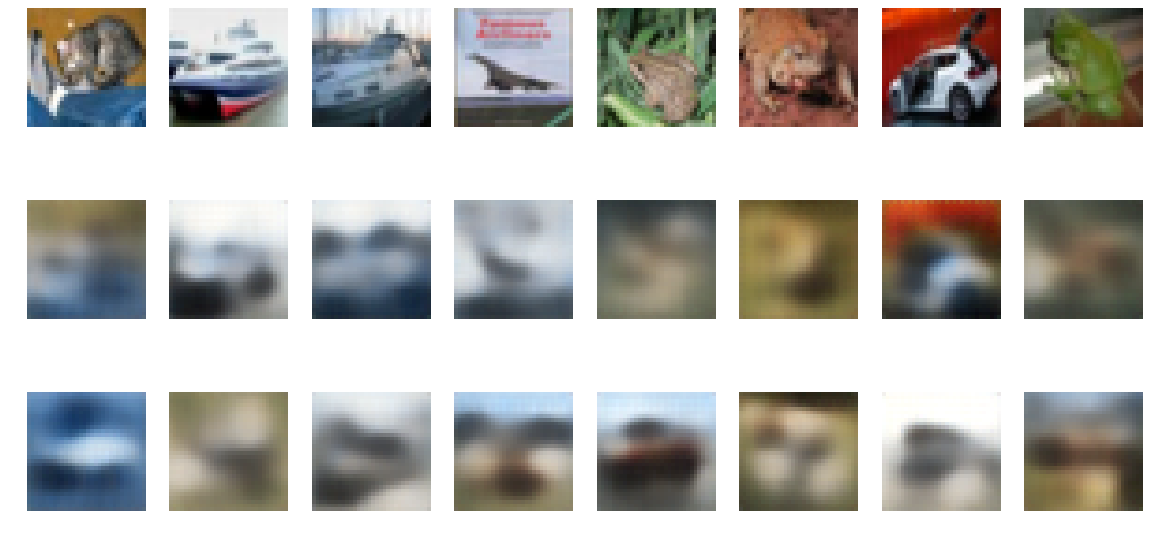

Train Epoch: 15 [0/50000 (0%)]	Loss: 226.590027
Train Epoch: 15 [25600/50000 (51%)]	Loss: 212.781525
====> Epoch: 15 Average loss: 221.8850
====> Test set loss: 221.9074


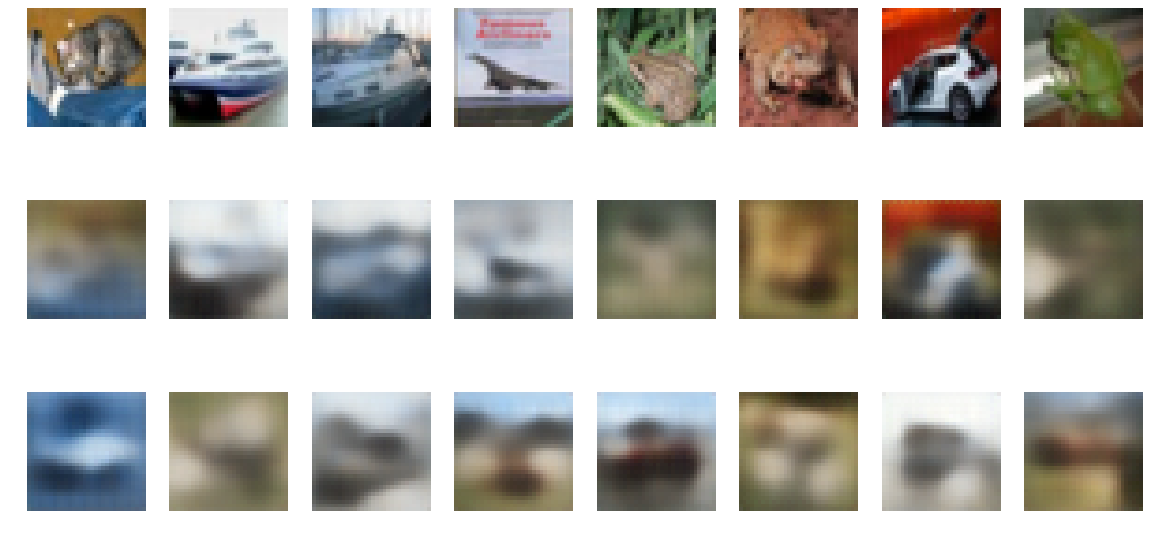

Train Epoch: 16 [0/50000 (0%)]	Loss: 221.721680
Train Epoch: 16 [25600/50000 (51%)]	Loss: 206.616791
====> Epoch: 16 Average loss: 219.8147
====> Test set loss: 220.0913


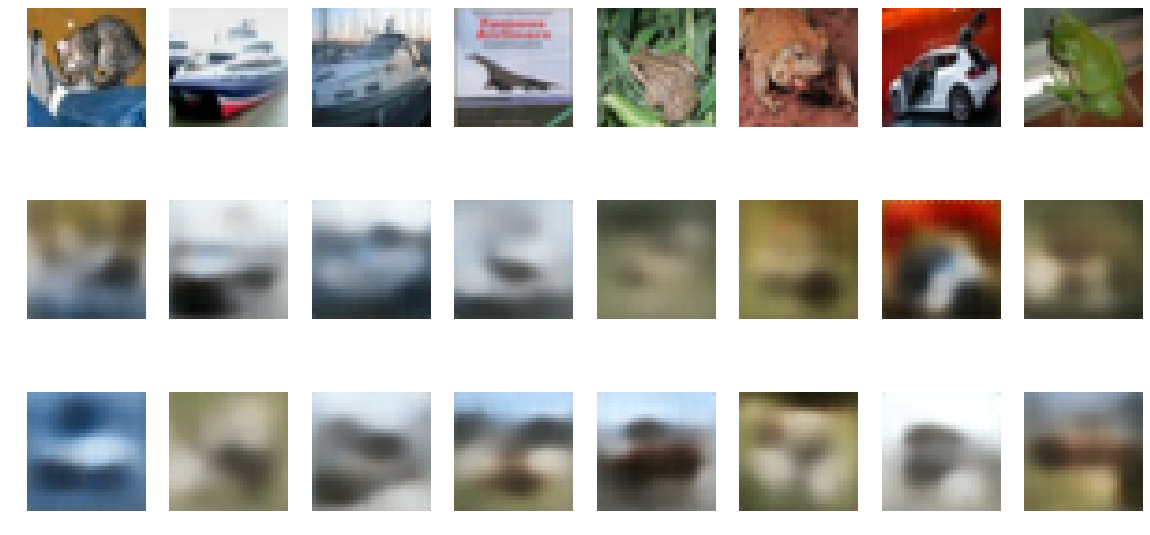

Train Epoch: 17 [0/50000 (0%)]	Loss: 213.456482
Train Epoch: 17 [25600/50000 (51%)]	Loss: 218.639130
====> Epoch: 17 Average loss: 218.1859
====> Test set loss: 217.5140


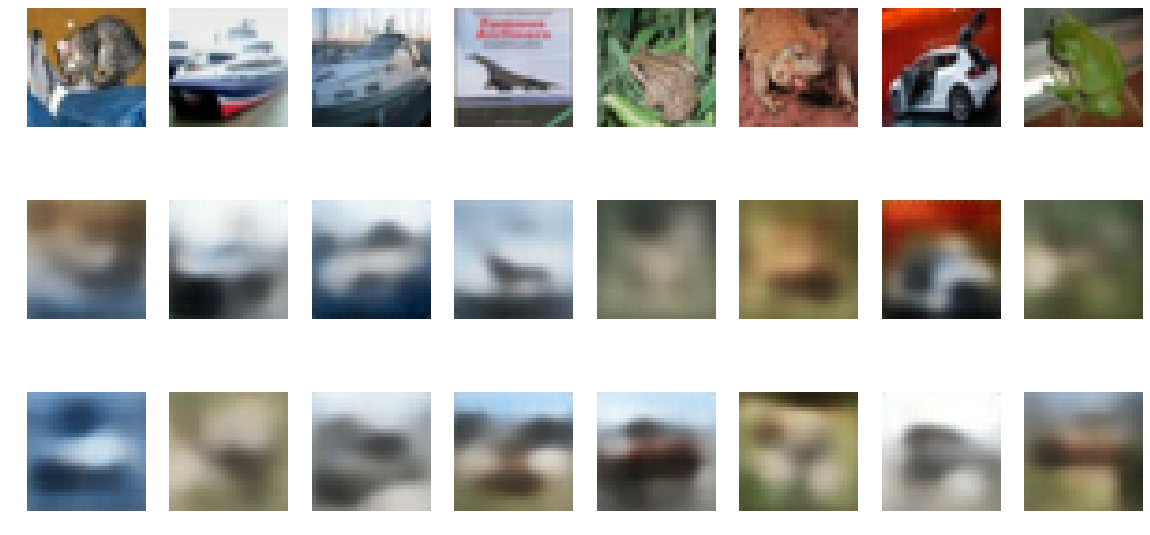

Train Epoch: 18 [0/50000 (0%)]	Loss: 218.327621
Train Epoch: 18 [25600/50000 (51%)]	Loss: 228.746979
====> Epoch: 18 Average loss: 217.0999
====> Test set loss: 215.5108


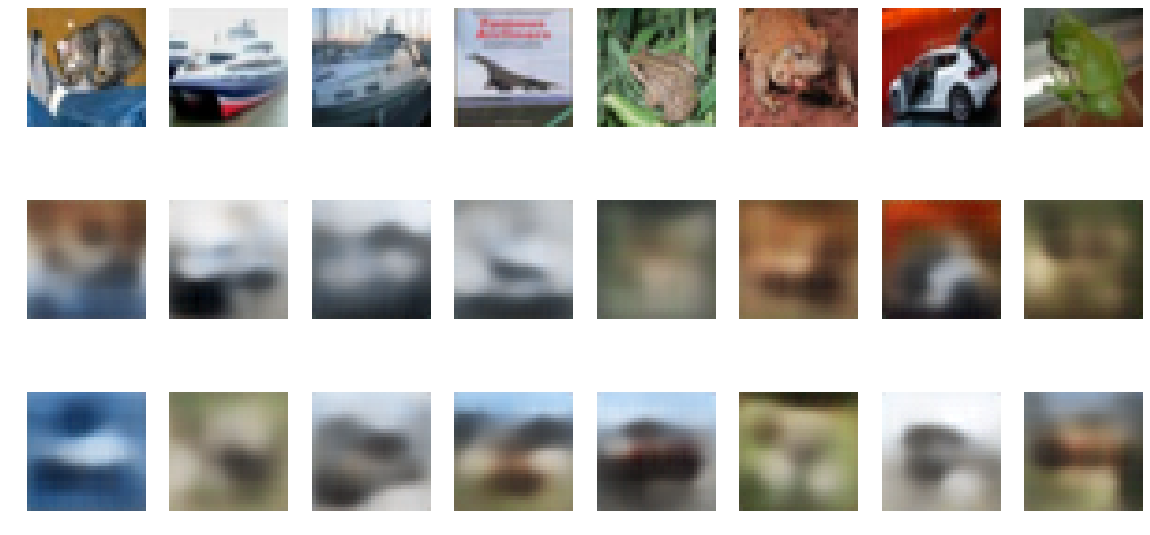

Train Epoch: 19 [0/50000 (0%)]	Loss: 220.305450
Train Epoch: 19 [25600/50000 (51%)]	Loss: 214.156113
====> Epoch: 19 Average loss: 215.4546
====> Test set loss: 212.5424


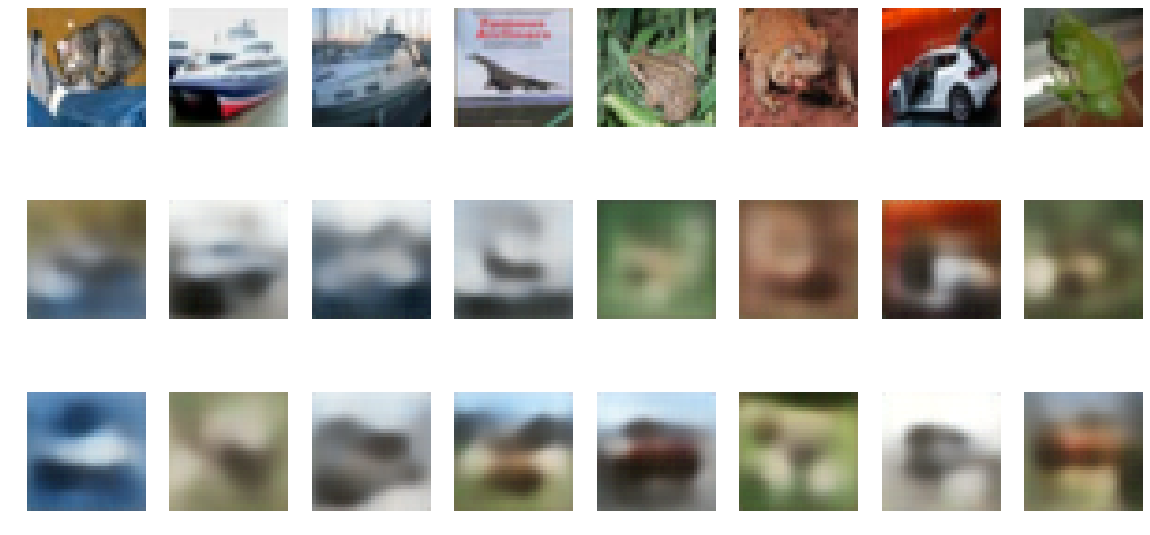

Train Epoch: 20 [0/50000 (0%)]	Loss: 213.767487
Train Epoch: 20 [25600/50000 (51%)]	Loss: 206.443390
====> Epoch: 20 Average loss: 213.4169
====> Test set loss: 213.9159


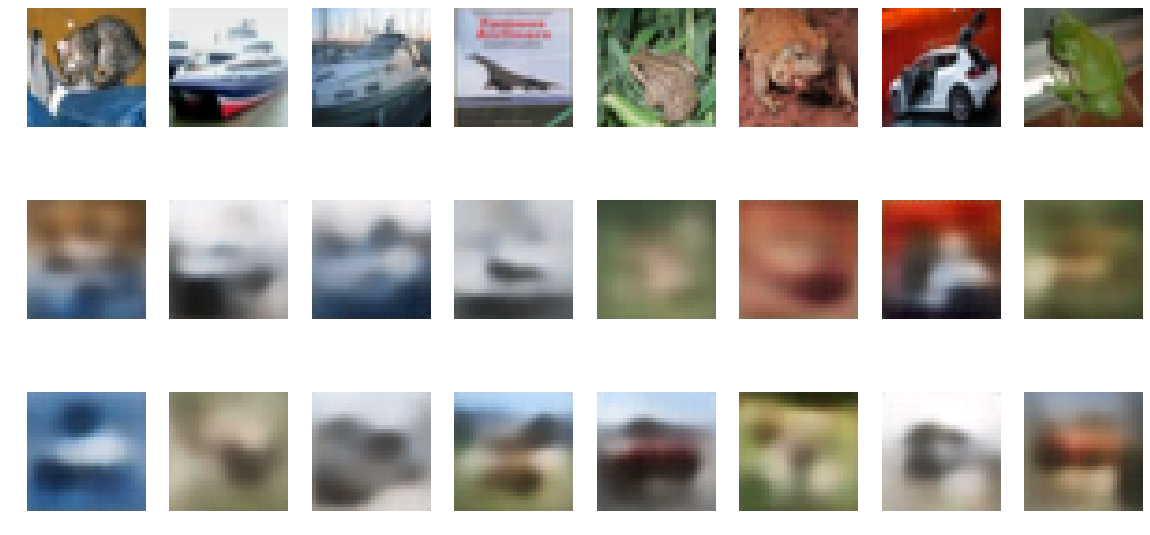

Train Epoch: 21 [0/50000 (0%)]	Loss: 209.071671
Train Epoch: 21 [25600/50000 (51%)]	Loss: 199.426758
====> Epoch: 21 Average loss: 212.5119
====> Test set loss: 226.9301


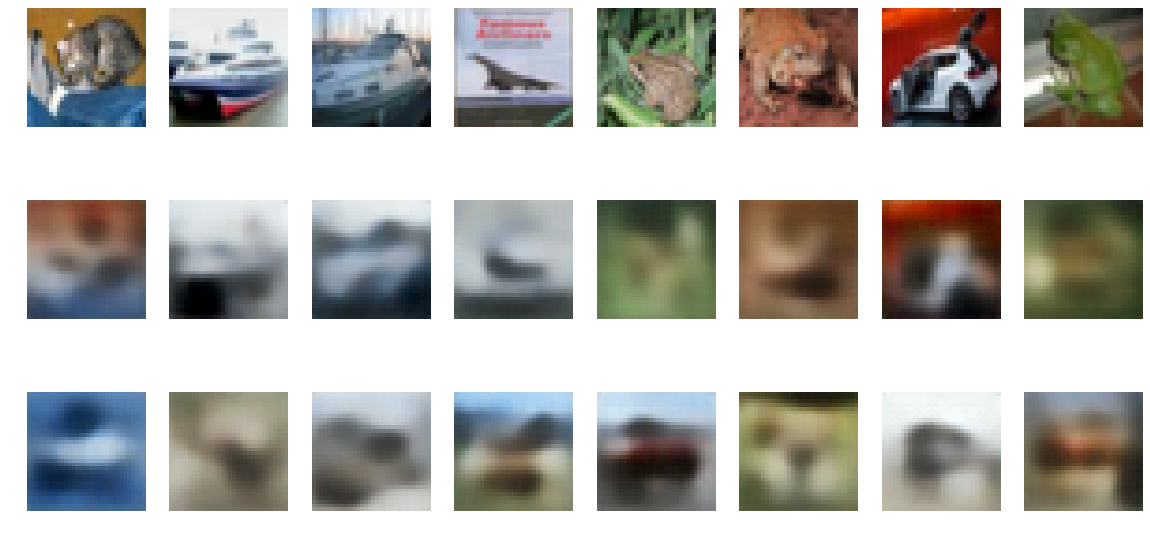

Train Epoch: 22 [0/50000 (0%)]	Loss: 213.831543
Train Epoch: 22 [25600/50000 (51%)]	Loss: 212.687134
====> Epoch: 22 Average loss: 212.1353
====> Test set loss: 214.9941


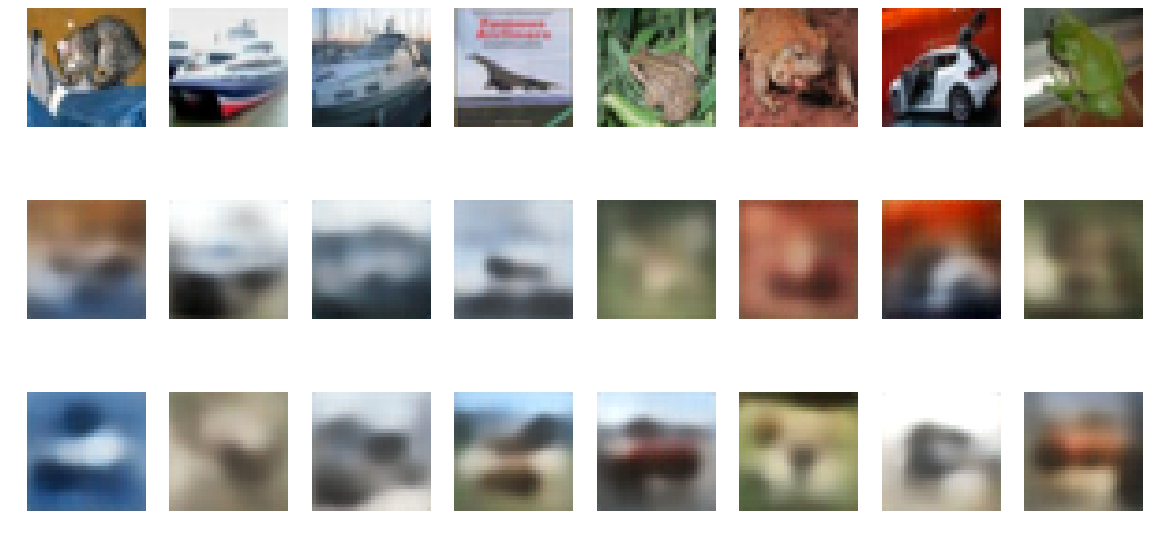

Train Epoch: 23 [0/50000 (0%)]	Loss: 218.738983
Train Epoch: 23 [25600/50000 (51%)]	Loss: 210.846817
====> Epoch: 23 Average loss: 211.2709
====> Test set loss: 210.2882


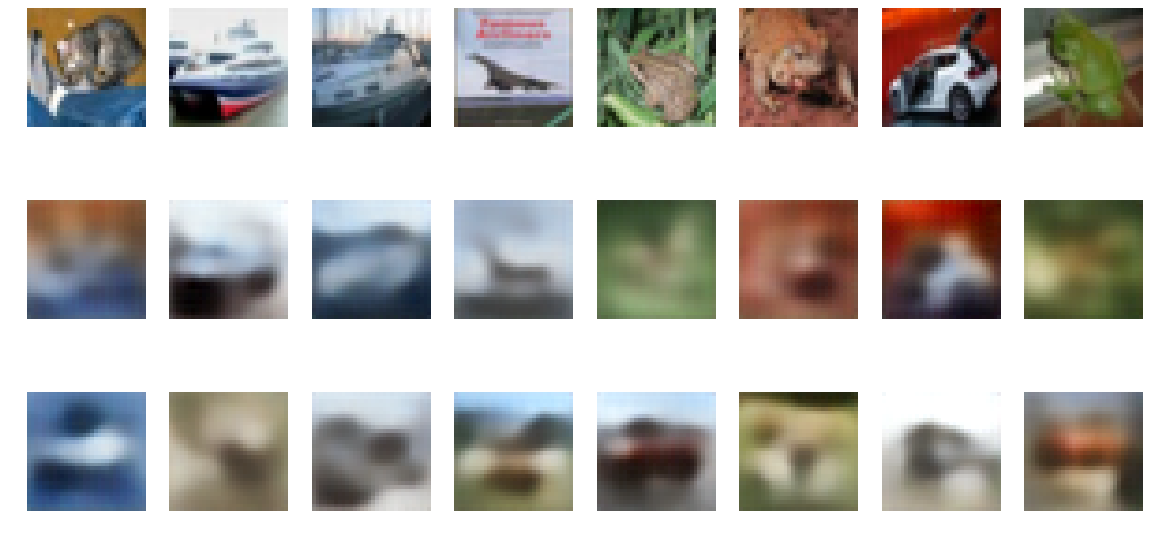

Train Epoch: 24 [0/50000 (0%)]	Loss: 215.895752
Train Epoch: 24 [25600/50000 (51%)]	Loss: 213.062347
====> Epoch: 24 Average loss: 210.0756
====> Test set loss: 210.2555


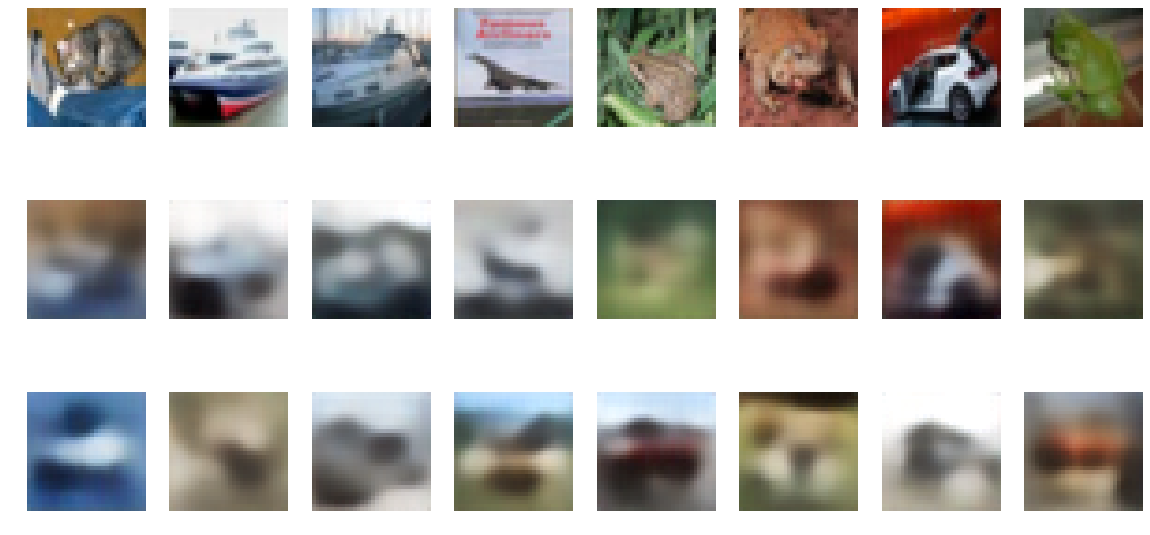

Train Epoch: 25 [0/50000 (0%)]	Loss: 214.580948
Train Epoch: 25 [25600/50000 (51%)]	Loss: 214.520447
====> Epoch: 25 Average loss: 209.2207
====> Test set loss: 208.1137


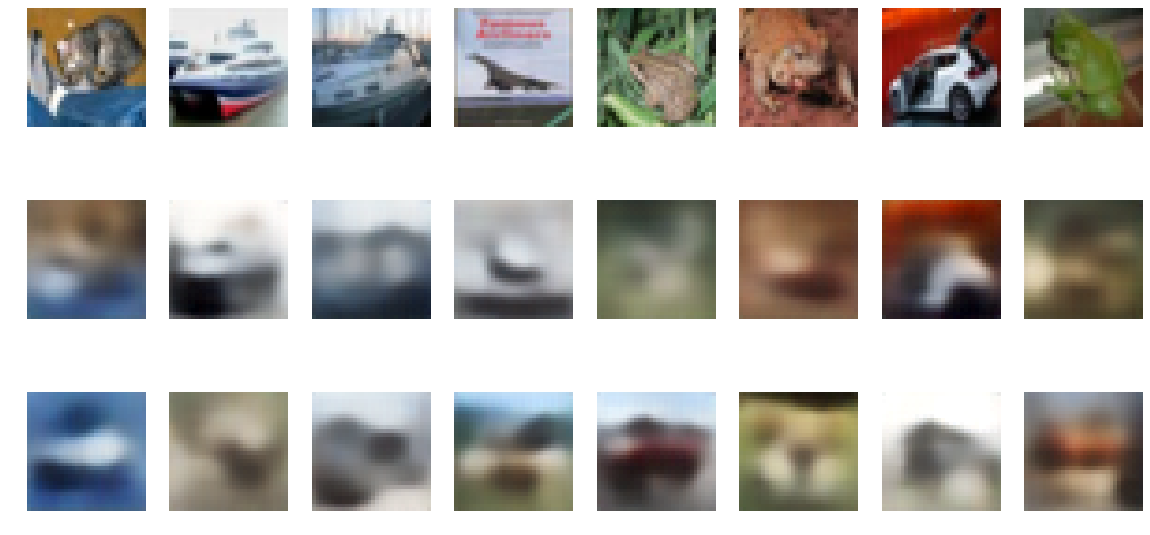

Train Epoch: 26 [0/50000 (0%)]	Loss: 206.405701
Train Epoch: 26 [25600/50000 (51%)]	Loss: 214.373352
====> Epoch: 26 Average loss: 208.7714
====> Test set loss: 213.8913


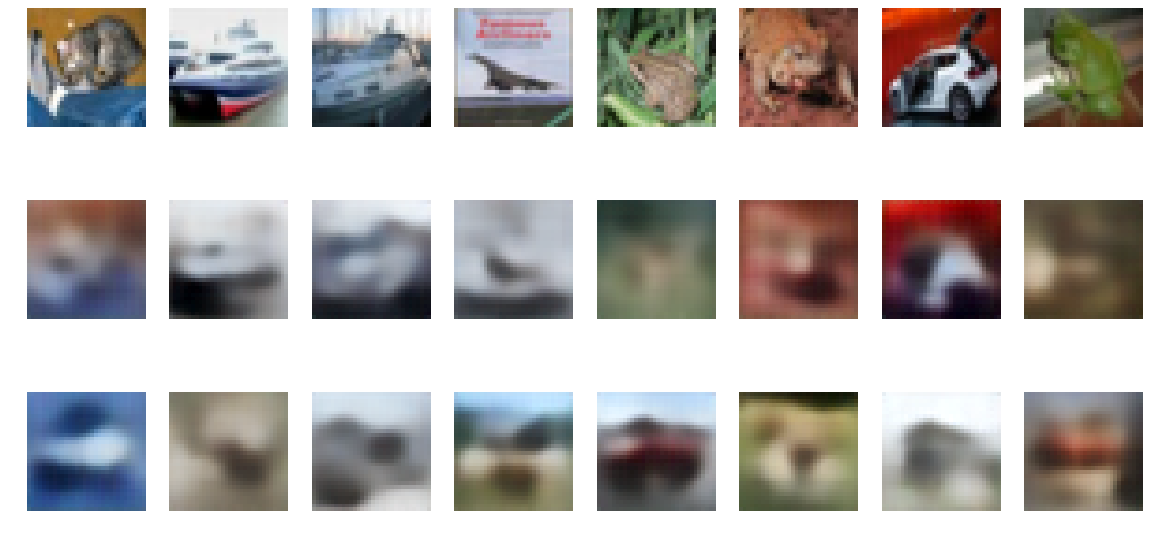

Train Epoch: 27 [0/50000 (0%)]	Loss: 208.806580
Train Epoch: 27 [25600/50000 (51%)]	Loss: 203.557434
====> Epoch: 27 Average loss: 207.4816
====> Test set loss: 206.9923


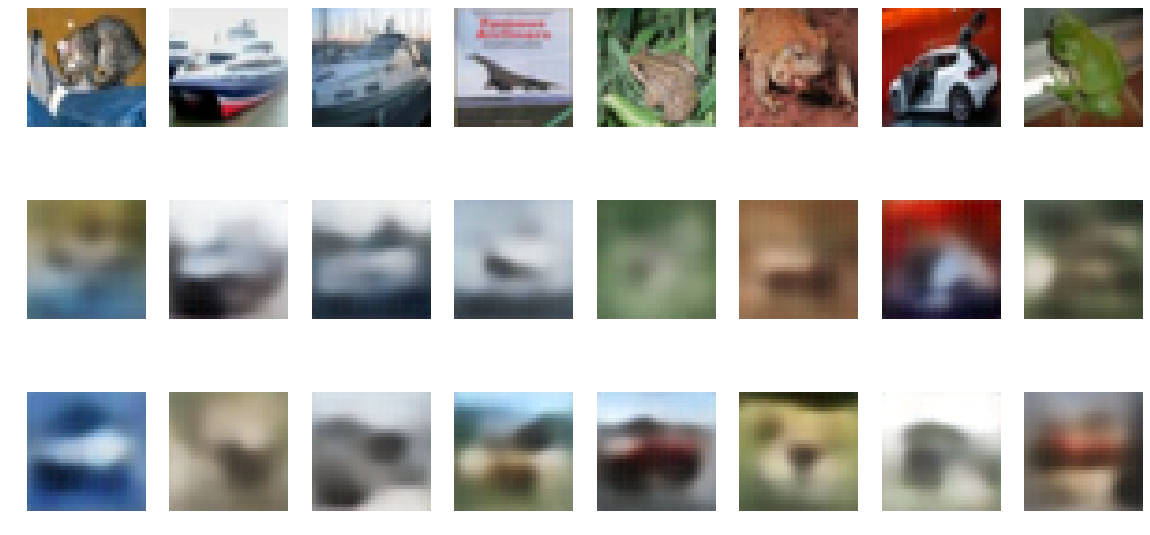

Train Epoch: 28 [0/50000 (0%)]	Loss: 211.762360
Train Epoch: 28 [25600/50000 (51%)]	Loss: 200.310699
====> Epoch: 28 Average loss: 206.8891
====> Test set loss: 220.9196


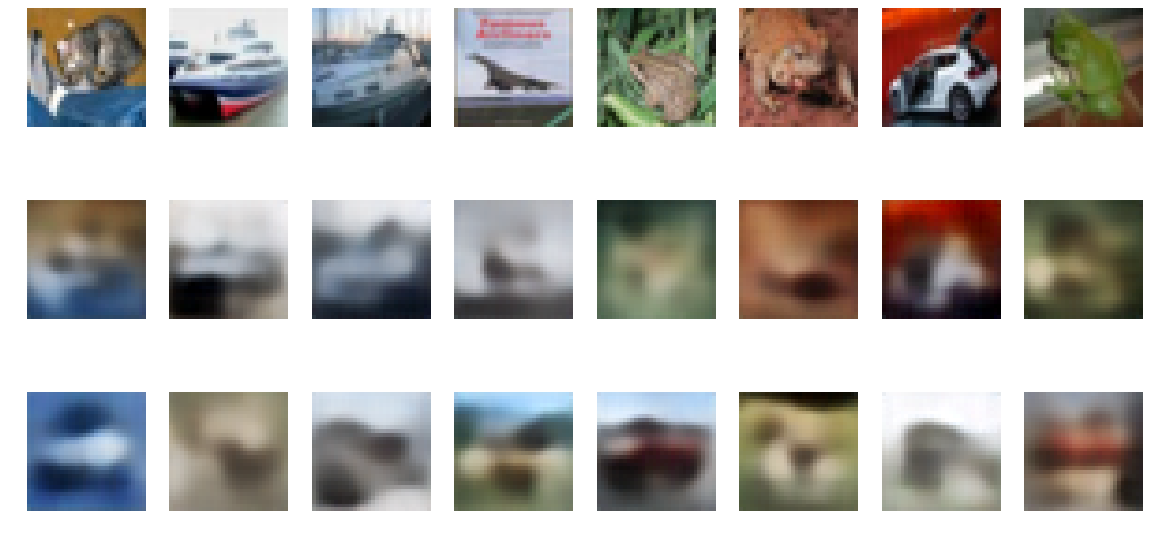

Train Epoch: 29 [0/50000 (0%)]	Loss: 213.372986
Train Epoch: 29 [25600/50000 (51%)]	Loss: 202.751740
====> Epoch: 29 Average loss: 205.7413
====> Test set loss: 215.7628


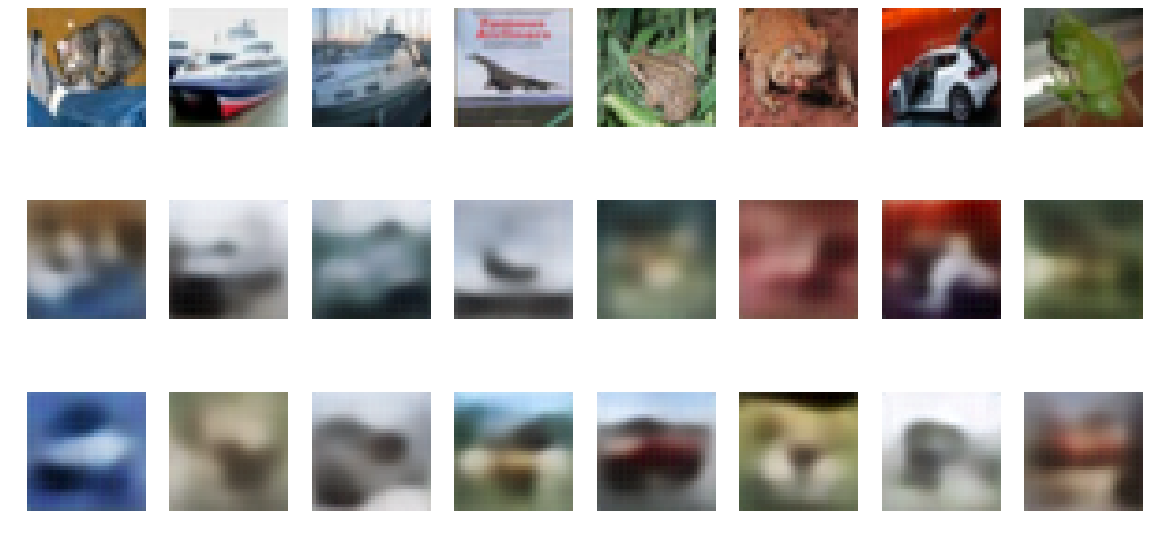

Train Epoch: 30 [0/50000 (0%)]	Loss: 205.467514
Train Epoch: 30 [25600/50000 (51%)]	Loss: 197.663376
====> Epoch: 30 Average loss: 205.8079
====> Test set loss: 204.5927


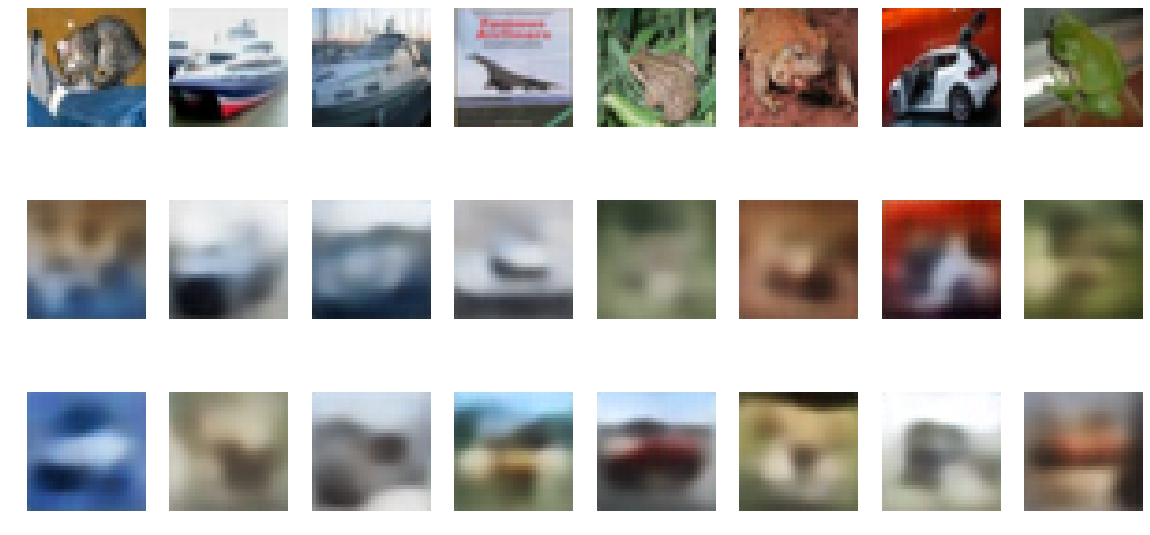

Train Epoch: 31 [0/50000 (0%)]	Loss: 202.338577
Train Epoch: 31 [25600/50000 (51%)]	Loss: 207.037659
====> Epoch: 31 Average loss: 204.9743
====> Test set loss: 219.7324


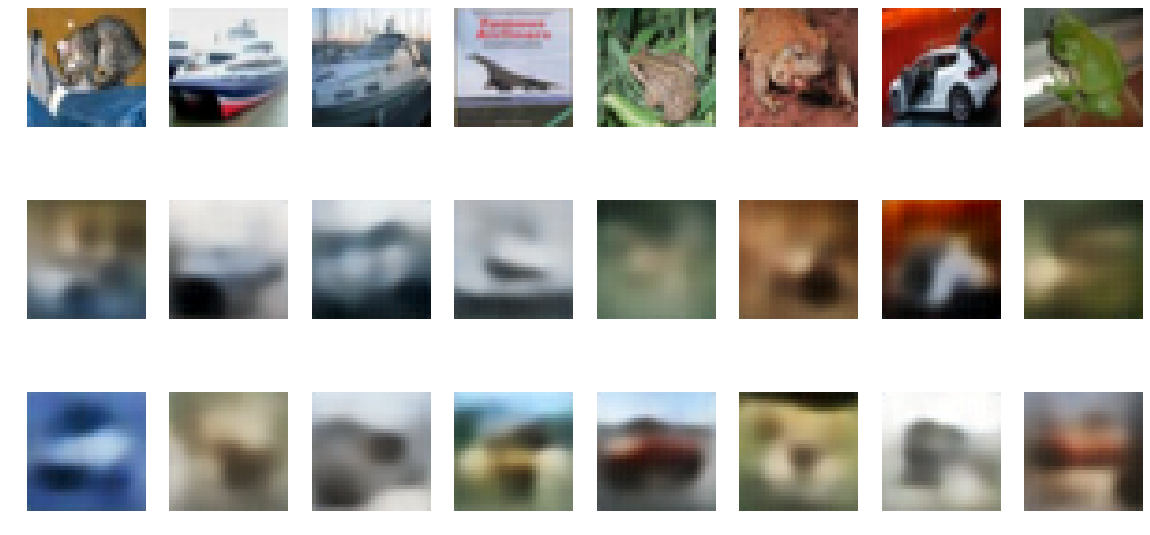

Train Epoch: 32 [0/50000 (0%)]	Loss: 207.279968
Train Epoch: 32 [25600/50000 (51%)]	Loss: 200.516586
====> Epoch: 32 Average loss: 204.6101
====> Test set loss: 204.7956


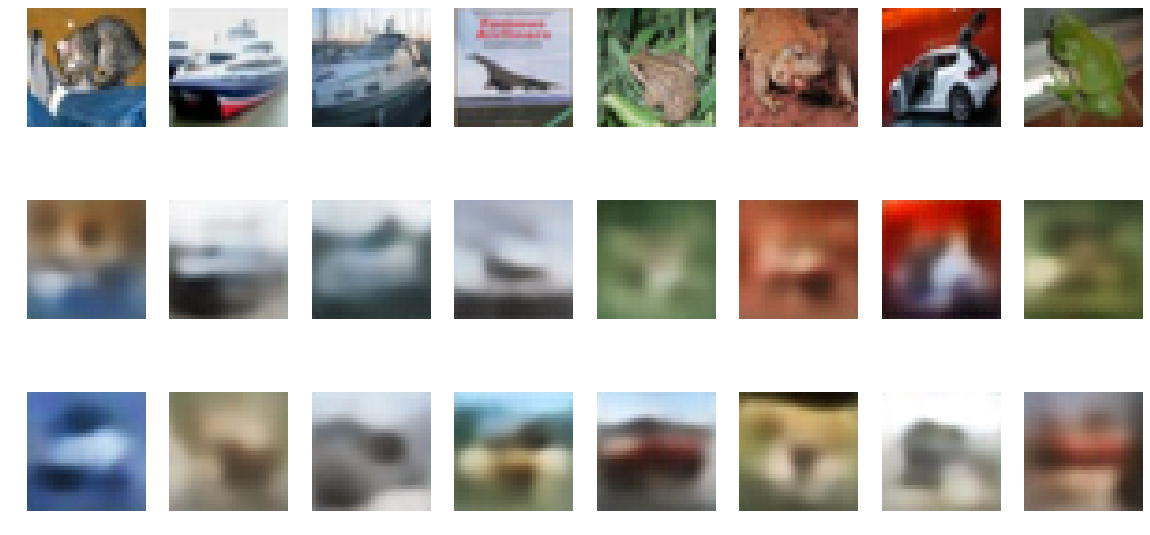

Train Epoch: 33 [0/50000 (0%)]	Loss: 211.670013
Train Epoch: 33 [25600/50000 (51%)]	Loss: 202.324188
====> Epoch: 33 Average loss: 204.6353
====> Test set loss: 203.8803


Train Epoch: 34 [0/50000 (0%)]	Loss: 208.091171
Train Epoch: 34 [25600/50000 (51%)]	Loss: 201.885406
====> Epoch: 34 Average loss: 202.7471
====> Test set loss: 203.5242


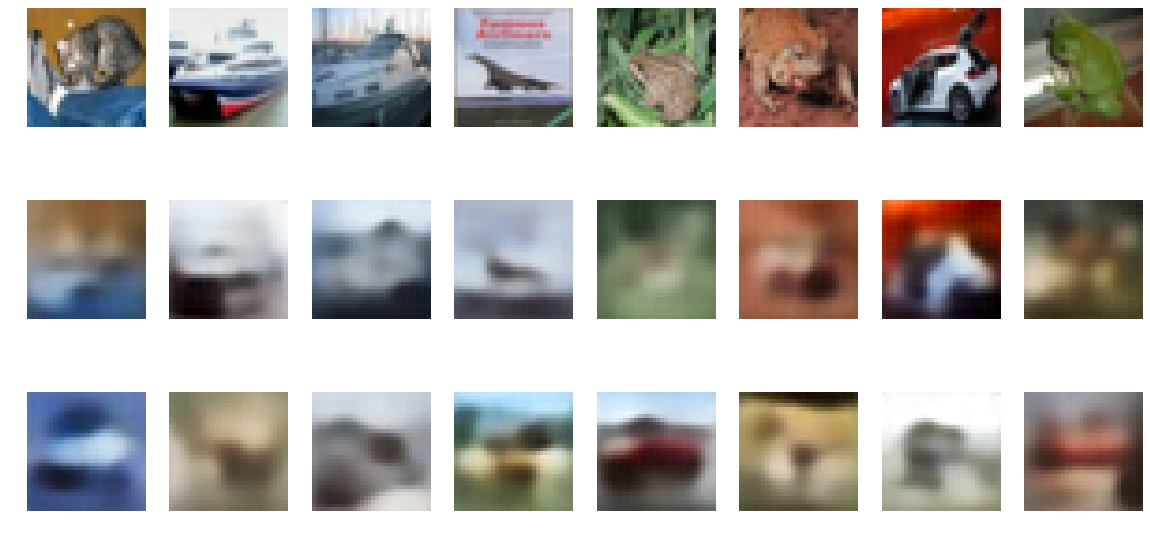

Train Epoch: 35 [0/50000 (0%)]	Loss: 201.833679
Train Epoch: 35 [25600/50000 (51%)]	Loss: 201.747467
====> Epoch: 35 Average loss: 202.9709
====> Test set loss: 202.8538


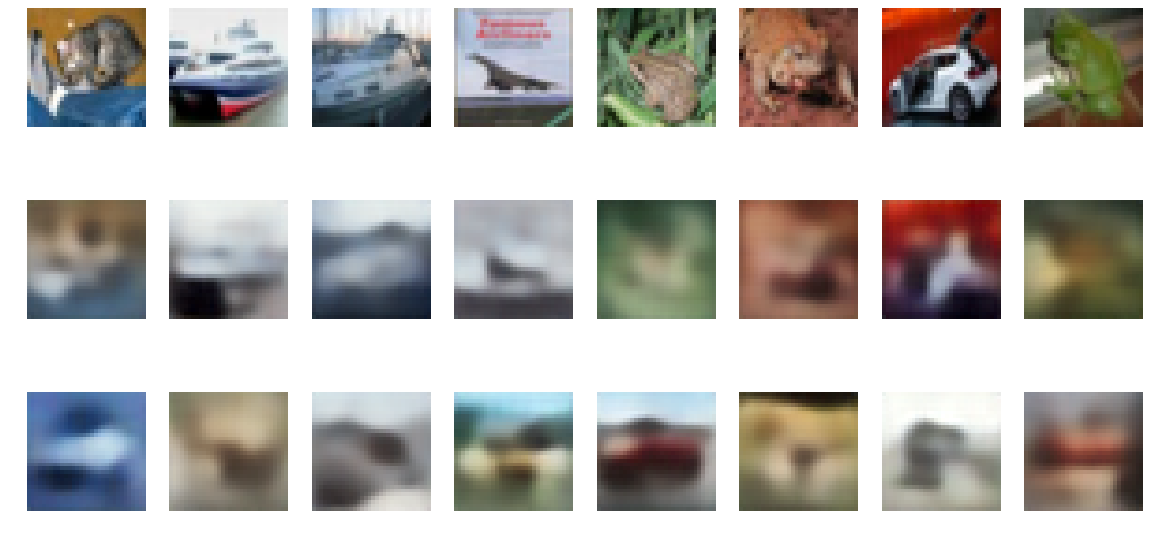

Train Epoch: 36 [0/50000 (0%)]	Loss: 211.633759
Train Epoch: 36 [25600/50000 (51%)]	Loss: 201.693222
====> Epoch: 36 Average loss: 202.6085
====> Test set loss: 201.1086


Train Epoch: 37 [0/50000 (0%)]	Loss: 201.937103
Train Epoch: 37 [25600/50000 (51%)]	Loss: 199.070160
====> Epoch: 37 Average loss: 201.8482
====> Test set loss: 204.6705


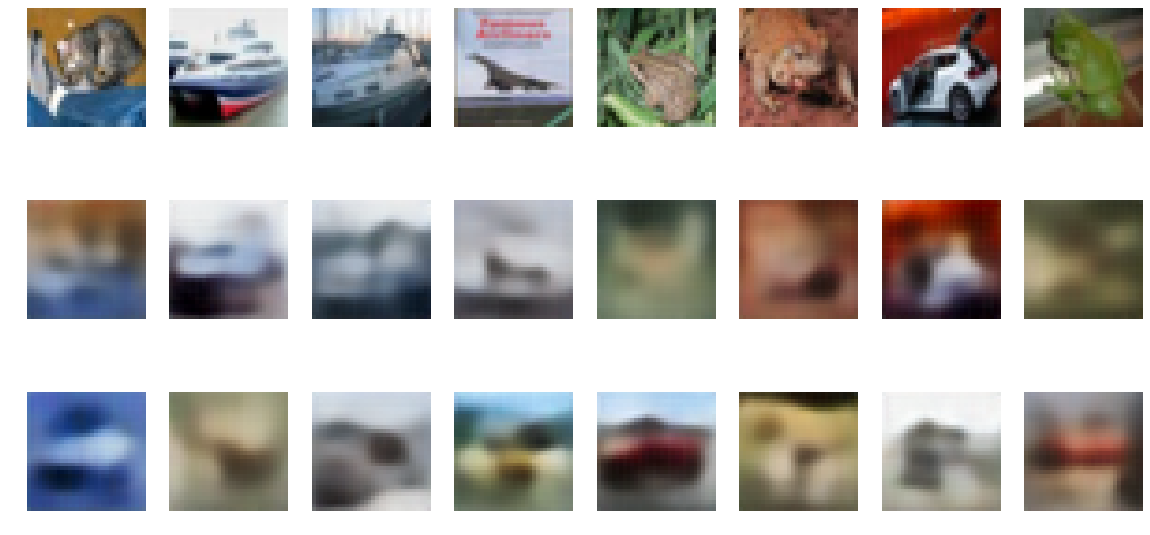

Train Epoch: 38 [0/50000 (0%)]	Loss: 206.831665
Train Epoch: 38 [25600/50000 (51%)]	Loss: 203.991714
====> Epoch: 38 Average loss: 202.0628
====> Test set loss: 202.8073


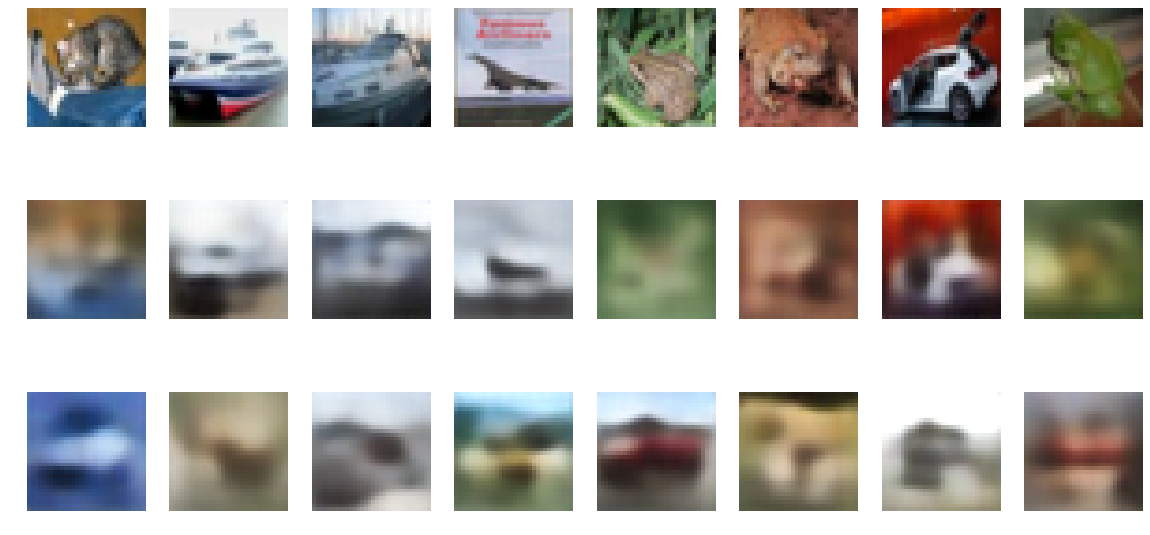

Train Epoch: 39 [0/50000 (0%)]	Loss: 206.312317
Train Epoch: 39 [25600/50000 (51%)]	Loss: 201.462036
====> Epoch: 39 Average loss: 201.6897
====> Test set loss: 200.4151


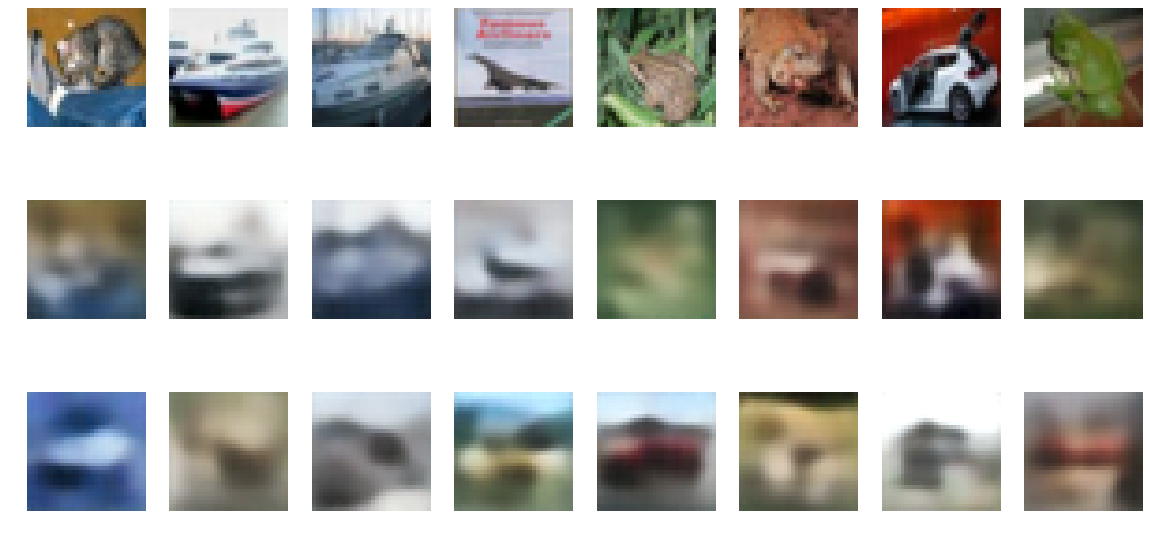

Train Epoch: 40 [0/50000 (0%)]	Loss: 204.958176
Train Epoch: 40 [25600/50000 (51%)]	Loss: 203.750931
====> Epoch: 40 Average loss: 200.8314
====> Test set loss: 202.6799


Train Epoch: 41 [0/50000 (0%)]	Loss: 197.797272
Train Epoch: 41 [25600/50000 (51%)]	Loss: 198.024017
====> Epoch: 41 Average loss: 200.8933
====> Test set loss: 201.8911


Train Epoch: 42 [0/50000 (0%)]	Loss: 205.182175
Train Epoch: 42 [25600/50000 (51%)]	Loss: 197.645111
====> Epoch: 42 Average loss: 200.0837
====> Test set loss: 201.1756


Train Epoch: 43 [0/50000 (0%)]	Loss: 202.760162
Train Epoch: 43 [25600/50000 (51%)]	Loss: 205.635223
====> Epoch: 43 Average loss: 200.5481
====> Test set loss: 203.7139


Train Epoch: 44 [0/50000 (0%)]	Loss: 195.166580
Train Epoch: 44 [25600/50000 (51%)]	Loss: 196.724777
====> Epoch: 44 Average loss: 200.4688
====> Test set loss: 210.1684


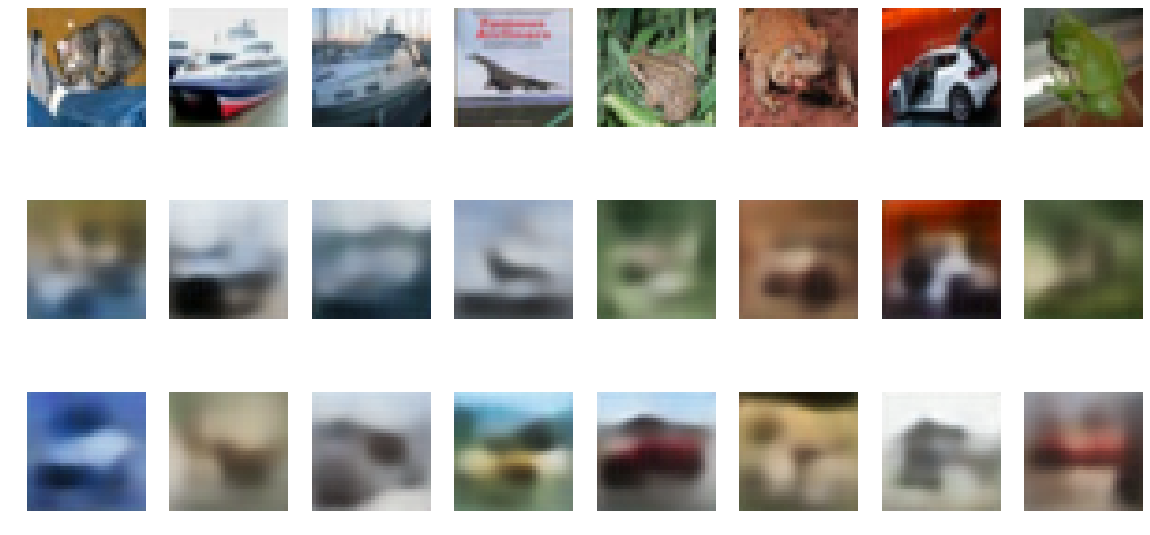

Train Epoch: 45 [0/50000 (0%)]	Loss: 201.143738
Train Epoch: 45 [25600/50000 (51%)]	Loss: 195.353012
====> Epoch: 45 Average loss: 200.3675
====> Test set loss: 198.6268


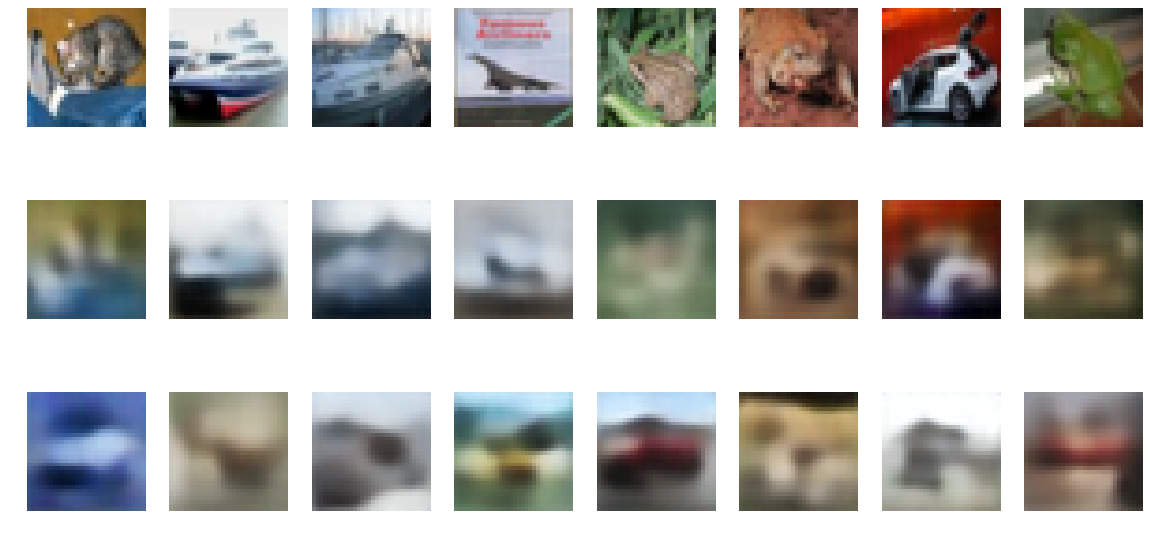

Train Epoch: 46 [0/50000 (0%)]	Loss: 209.318985
Train Epoch: 46 [25600/50000 (51%)]	Loss: 206.452866
====> Epoch: 46 Average loss: 199.7197
====> Test set loss: 202.9175


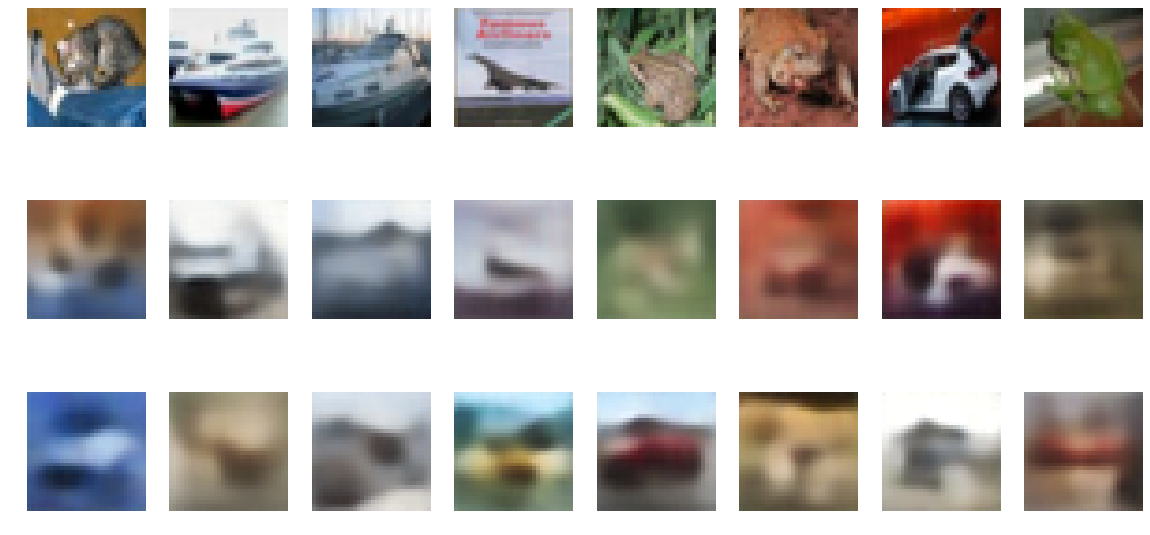

Train Epoch: 47 [0/50000 (0%)]	Loss: 198.161133
Train Epoch: 47 [25600/50000 (51%)]	Loss: 197.881287
====> Epoch: 47 Average loss: 198.6265
====> Test set loss: 199.6080


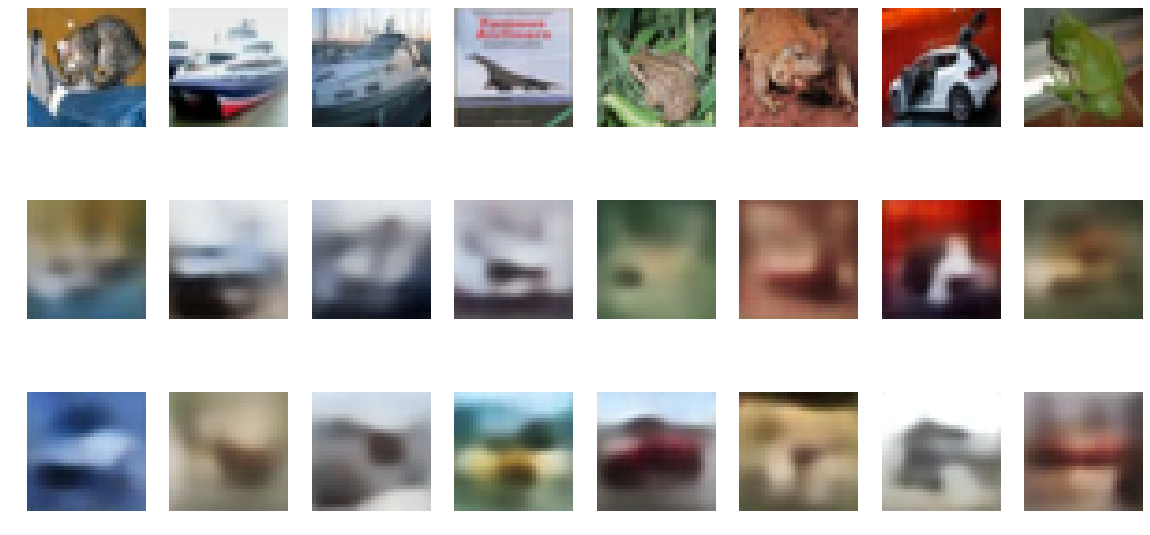

Train Epoch: 48 [0/50000 (0%)]	Loss: 201.869995
Train Epoch: 48 [25600/50000 (51%)]	Loss: 199.223419
====> Epoch: 48 Average loss: 198.2917
====> Test set loss: 197.0577


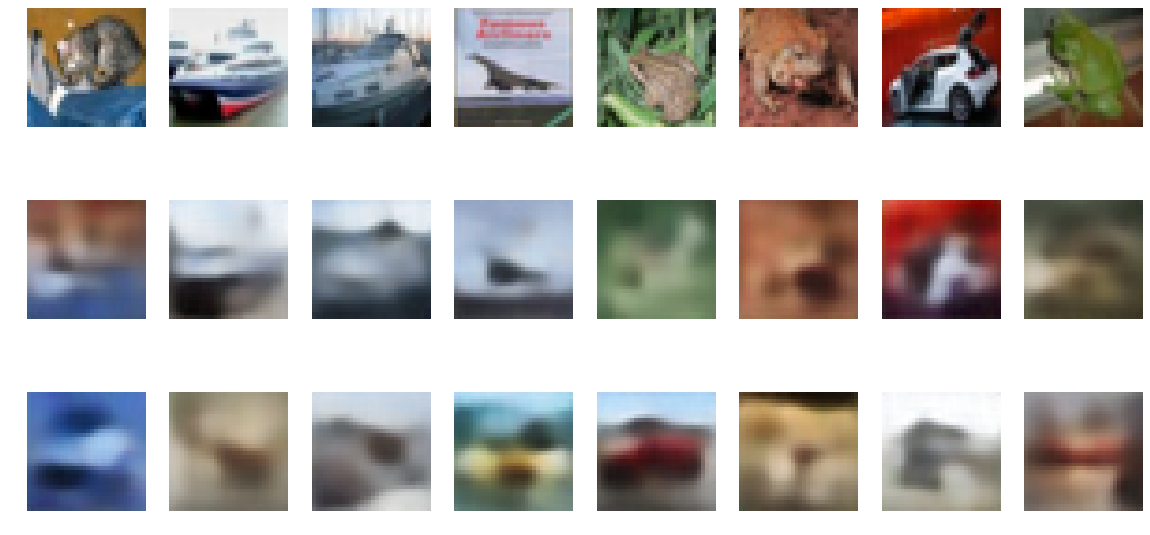

Train Epoch: 49 [0/50000 (0%)]	Loss: 190.961090
Train Epoch: 49 [25600/50000 (51%)]	Loss: 207.620880
====> Epoch: 49 Average loss: 198.2053
====> Test set loss: 196.3155


Train Epoch: 50 [0/50000 (0%)]	Loss: 194.639542
Train Epoch: 50 [25600/50000 (51%)]	Loss: 202.687088
====> Epoch: 50 Average loss: 197.9951
====> Test set loss: 198.5608


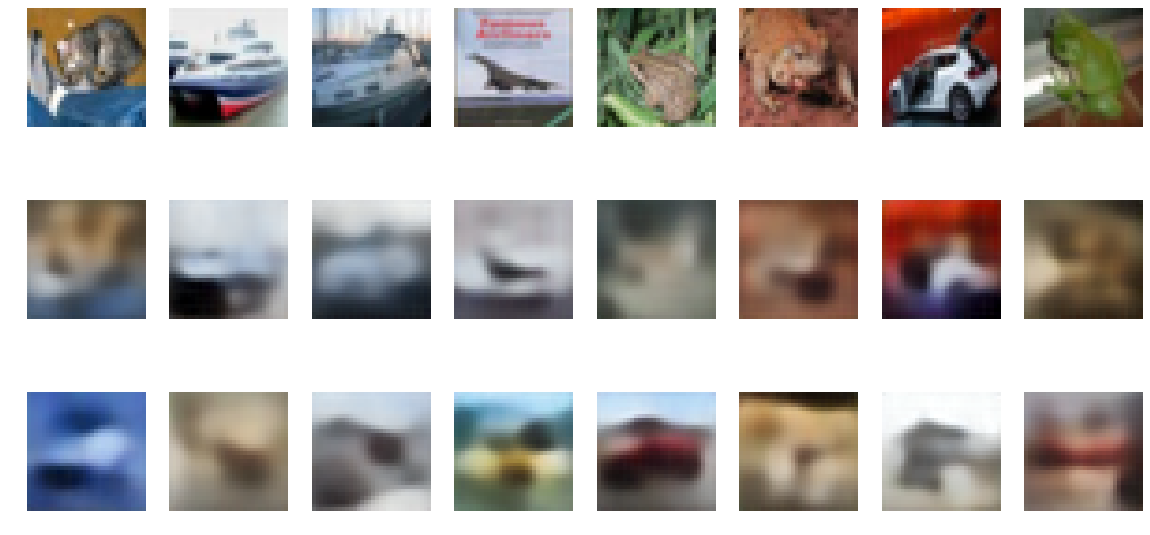

In [33]:
model = VAE().to(device)
print(f"# Parameters: {count_parameters(model)}")
optimizer = optim.Adam(model.parameters(), lr=1e-2)

fixed_z = torch.randn(8, 512).to(device)
fixed_x, _ = next(iter(test_loader))
fixed_x = fixed_x[:8].to(device)
fixed_x_unnormalized = ((fixed_x*0.5) + 0.5)

for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)
    
    fig, axs = plt.subplots(3, 8, figsize=(20, 10))
    with torch.no_grad():
        # Reconstruction
        recon_x, *_ = model(fixed_x)
        recon_x = torch.clamp((recon_x*0.5) + 0.5, 0, 1)
        for h in range(8):
            axs[0][h].imshow(fixed_x_unnormalized.cpu()[h].permute(1, 2, 0).numpy())
            axs[0][h].set_axis_off()

        for h in range(8):
            axs[1][h].imshow(recon_x.cpu()[h].permute(1, 2, 0).numpy())
            axs[1][h].set_axis_off()

        # Generated samples
        fixed_z_gen = model.decode(fixed_z).cpu()
        fixed_z_gen = torch.clamp((fixed_z_gen*0.5) + 0.5, 0, 1)
        for h in range(8):
            axs[2][h].imshow(fixed_z_gen[h].permute(1, 2, 0).numpy())
            axs[2][h].set_axis_off()
        plt.show()
